In [1]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet as pr
#import mplcursors
from datetime import datetime

Matplotlib created a temporary config/cache directory at C:\Users\MATHEU~1\AppData\Local\Temp\matplotlib-pglw7vyg because the default path (C:\Users\Matheus Alves\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
C:\Users\Matheus Alves\Documents\git_tcc\time_series_precipitation\ts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sns.set_style("darkgrid")
%matplotlib inline

## Carregando Base de Dados, Dividindo entre Teste e Treino e Alterando para Padrão Prophet


In [5]:
rainfall = pd.read_csv(r"C:\Users\Matheus Alves\Documents\git_tcc\time_series_precipitation\Dataset\dados_chuvas1.csv", parse_dates=True)

In [6]:
rainfall['Date'] = pd.to_datetime(rainfall['Date'], format="%Y/%m/%d")
#rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

In [7]:
train = rainfall.iloc[:-14]
test = rainfall.iloc[-14:]

In [8]:
 train.columns = ['ds','y']

## Instanciando Prophet e Fazendo uma Previsão com Ajustes Para o Verão e Sazonalidade Quadrimestral

In [23]:
rainfall['month'] = pd.DatetimeIndex(rainfall.Date).month

rainfall_jan = rainfall[(rainfall.month == 1)]
rainfall_feb = rainfall[(rainfall.month == 2)]
rainfall_mar = rainfall[(rainfall.month == 3)]
rainfall_oc = rainfall[(rainfall.month == 10)]
rainfall_nov = rainfall[(rainfall.month == 11)]
rainfall_dec = rainfall[(rainfall.month == 12)]

all_dfs = [rainfall_oc,rainfall_nov,rainfall_dec,rainfall_jan,rainfall_feb,rainfall_mar]

rainfall_summer = pd.concat(all_dfs).reset_index(drop=True)
rainfall_summer

,Date,Precipitation,month
0,1984-10-31,31.1,10
1,1985-10-31,11.2,10
2,1986-10-31,43.9,10
3,1987-10-31,89.9,10
4,1988-10-31,170.1,10
...,...,...,...
224,2017-03-31,160.4,3
225,2018-03-31,220.5,3
226,2019-03-31,239.6,3
227,2020-03-31,69.4,3


In [24]:
#adicionando os meses de verão para uma previsão mais precisa
summer = pd.DataFrame({'holiday': 'summer',
                       'ds': rainfall_summer['Date']})

In [51]:
model = pr(interval_width=0.95, yearly_seasonality=100, daily_seasonality=False, weekly_seasonality=False, holidays=summer, seasonality_mode='additive')
model.add_seasonality('quarterly', period=91.25, fourier_order=10, mode='additive')
model.fit(train)
future = model.make_future_dataframe(periods=14, freq='M')

18:07:11 - cmdstanpy - INFO - Chain [1] start processing
18:07:11 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
rainfall_pred = model.predict(future)

## Visualizando os Dados da Série Global e a Comparação entre Teste e Previsão

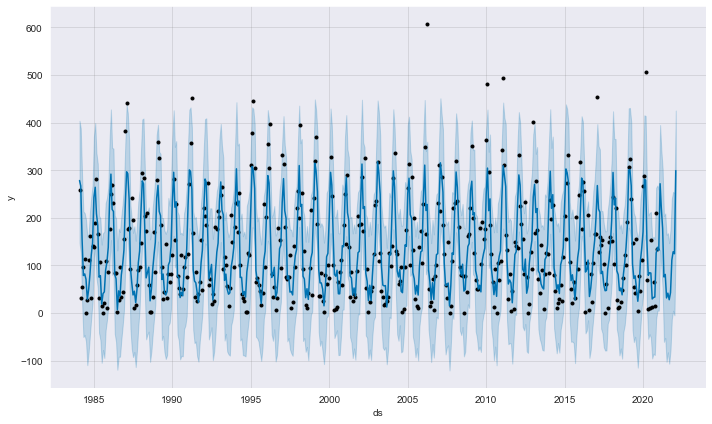

In [53]:
final_model = model.plot(rainfall_pred)

In [54]:
previsao = rainfall_pred[['ds','yhat']].iloc[-14:]
previsao.columns = ['Date','Precipitation']
previsao = previsao.round(1)

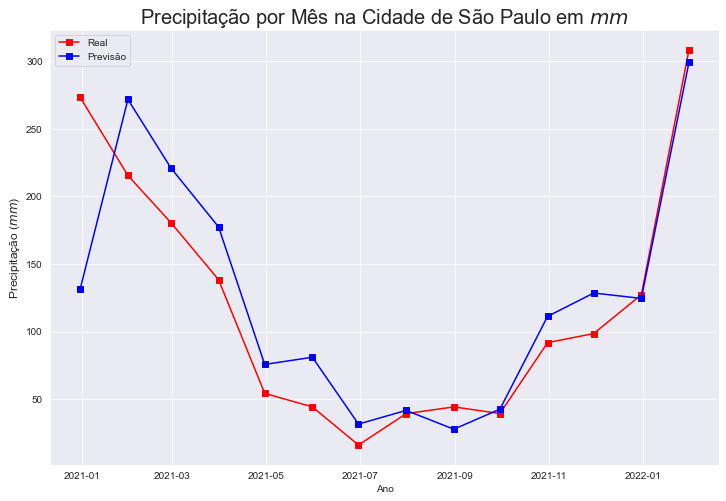

In [55]:
fig = plt.figure(figsize=(12, 8))

plt.plot(test.Date, test.Precipitation, 's-r')
plt.plot(previsao.Date, previsao.Precipitation, 's-b')

plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)

plt.ylabel('Precipitação ($mm$)', fontsize=12)
plt.xlabel('Ano')
plt.legend(['Real', 'Previsão']);
plt.show() 

In [56]:
test #valores utilizados para testar o modelo (valores reais)

,Date,Precipitation
443,2020-12-31,273.2
444,2021-01-31,215.5
445,2021-02-28,180.6
446,2021-03-31,138.4
447,2021-04-30,54.4
448,2021-05-31,44.4
449,2021-06-30,16.2
450,2021-07-31,39.4
451,2021-08-31,44.4
452,2021-09-30,39.5


In [57]:
previsao #valores previstos pelo modelo

,Date,Precipitation
443,2020-12-31,131.8
444,2021-01-31,271.7
445,2021-02-28,221.0
446,2021-03-31,177.4
447,2021-04-30,75.8
448,2021-05-31,81.1
449,2021-06-30,31.7
450,2021-07-31,41.8
451,2021-08-31,27.9
452,2021-09-30,42.7


# Avaliando o Modelo

In [58]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [59]:
real_value = np.array(test['Precipitation'])
pred_value = np.array(previsao['Precipitation'])

In [60]:
smape = MeanAbsolutePercentageError(symmetric=True)
smape(real_value, pred_value) * 100

28.845780587733387